# Sentinel-1 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` test datacube environment
* **Products used:** 
s1_gamma0_scene
* **Prerequisites:** Read access of NCI project /g/data/dz56.


## Background

Sentinel 1A and 1B satellites, launched in 2014 and 2016 respectively, currently collects C-band SAR data every 12 days over Australia. Spatial resolution of the Sentinel-1 data is approximately 20m.

The current version of normalized backscatter (gamma0) product is processed to CARD4L recommendations, with corrections applied including orbit updates, border noise removal, thermal noise removal, radiometric calibration, radiometric terrain correction and orthorectification. Reference for this workflow can be found at https://doi.org/10.3390/data4030100

This product will be replaced when a different but compatible dataset becomes available in 2020. 

## Description
This notebook demonstrates how to load Sentinel-1 data using the `sarcube` wrapper. 
Topics covered include:

* Using the `sarcube` to load in Sentinel-1 backscatter data with default parameters.
* Creating a mean composite of Sentinel-1 backscatter.
* Using the `sarcube` to load in Sentinel-1 backscatter data with different speckle filter options.

***

## Getting started

The "Load packages" and "Connect to the datacube" cells must be executed first. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
#import numpy as np
#import xarray as xr
import sys

sys.path.append('../Scripts')
from dea_sartools import sarcube


### Connect to the datacube

Use the `sarcube` wrapper to connect to the datacube. 
Sentinel-1 test data is not yet available through the production datacube so a configuration file is provided to connect to the test database.

In [2]:
dc = sarcube(app="Sentinel_1", config="../Supplementary_data/SAR_testcube/radar.conf")

## Load Sentinel-1 data

In [3]:
# check available bands for sentinel-1 data
dc.list_measurements().loc['s1_gamma0_scene']

,name,dtype,units,nodata,aliases,spectral_definition,flags_definition
measurement,,,,,,,
vh,vh,float32,1,0,NaN,NaN,NaN
vv,vv,float32,1,0,NaN,NaN,NaN
lia,lia,float32,1,0,"[local_incidence_angle, linci, incidence]",NaN,NaN


### Load data with default parameters

In [226]:
lat, lon, buffer = -18.218330, 122.209456, 0.05

lon=149.44908142089432
lat=-21.780542971126668
buffer=0.05
buffer_y=0.08

# create a query over Canberra
query = {'lon': (lon - buffer, lon + buffer), 
         'lat': (lat - buffer_y, lat + buffer_y),
         'time': ('2018-01-01', '2019-12-31')
        }



In [227]:
# no speckle filter and convert output to decibel 
data = dc.load(product='s1_gamma0_scene', 
               group_by='solar_day',
               speckle_filter=None, db=True, verbose=True,
               **query)

Converting to db...


In [221]:
# import odc.ui 

In [222]:
# odc.ui.DcViewer(dc=dc, time='2018')

In [28]:
# # filter with lia
# mask = data.lia < 60
# data = data.where(mask)

In [228]:
# add a ratio band for visualisation
# use subtraction in db (log) space 
data['vhvv'] = data.vh - data.vv

In [229]:
# rescale the data for improved contrast
m, s = data[['vv','vh','vhvv']].mean(), data[['vv','vh','vhvv',]].std()
landsat_ds = (data[['vv','vh','vhvv']] - m)/s

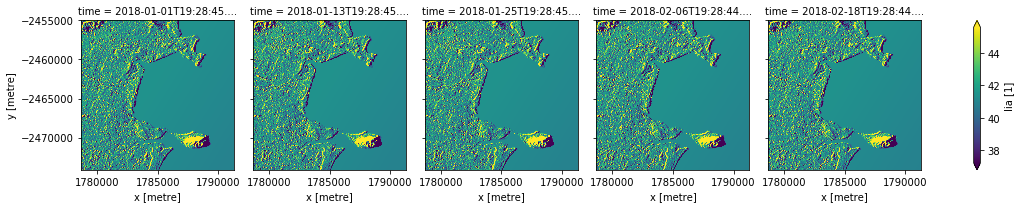

In [230]:
data.lia.isel(time=slice(0, 5)).plot(col='time', robust=True)

In [231]:
from dea_coastaltools import tidal_tag

In [232]:
landsat_ds.attrs['crs'] = data.crs

## Model tide heights
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to calculate the height of the tide at the exact moment each Landsat image was acquired. 
This will allow us to built a sorted time series of images taken at low tide to high tide, which we will use to generate the intertidal elevation model.

The `tidal_tag` function below uses the [OTPS TPXO8 tidal model](http://volkov.oce.orst.edu/tides/global.html) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_height` attribute in our dataset. 

> **Note:** this function can only model tides correctly if the centre of your study area is located over water. 
If this isn't the case, you can specify a custom tide modelling location by passing a coordinate to `tidepost_lat` and `tidepost_lon` (e.g. `tidepost_lat=-27.73, tidepost_lon=153.46`).

In [233]:
# Calculate tides for each timestep in the satellite dataset
landsat_ds = tidal_tag(ds=landsat_ds, tidepost_lat=None, tidepost_lon=None)

# Print the output dataset with new `tide_height` variable
print(landsat_ds)


Setting tide modelling location from dataset centroid: 149.45, -21.78
<xarray.Dataset>
Dimensions:      (time: 31, x: 505, y: 765)
Coordinates:
  * y            (y) float64 -2.455e+06 -2.455e+06 ... -2.474e+06 -2.474e+06
  * x            (x) float64 1.779e+06 1.779e+06 ... 1.791e+06 1.791e+06
  * time         (time) datetime64[ns] 2018-01-01T19:28:45.729120 ... 2018-12-27T19:28:52.730960
Data variables:
    vv           (time, y, x) float64 1.374 0.7993 1.337 ... -0.9382 -1.262
    vh           (time, y, x) float64 1.291 0.6095 1.158 ... -2.976 -1.373 nan
    vhvv         (time, y, x) float64 0.5736 0.1658 0.425 ... -3.363 -0.9604 nan
    tide_height  (time) float64 -2.946 -1.604 1.046 1.379 ... -1.71 0.497 0.966
Attributes:
    crs:      EPSG:3577


Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Landsat across our time series: 

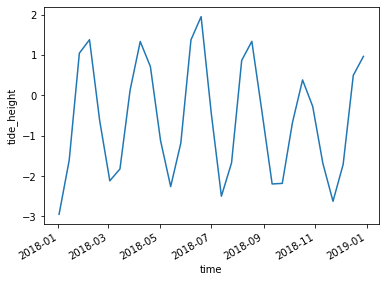

In [234]:
# Plot the resulting tide heights for each Landsat image:
landsat_ds.tide_height.plot()
plt.show()

## Create water index summary images from low to high tide

Using these tide heights, we can sort our Landsat dataset by tide height to reveal which parts of the landscape are inundated or exposed from low to high tide. 

Individual remote sensing images can be affected by noise, including clouds, sunglint and poor water quality conditions (e.g. sediment). 
To produce cleaner images that can be compared more easily between tidal stages, we can create 'summary' images or composites that combine multiple images into one image to reveal the 'typical' or median appearance of the landscape at different tidal stages. 
In this case, we use the median as the summary statistic because it prevents strong outliers (like stray clouds) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images, sort by tide and categorise each image into 9 discrete tidal intervals, ranging from the lowest (tidal interval 1) to the highest tides observed by Landsat (tidal interval 9). 
For more information on this method, refer to [Sagar et al. 2018](https://www.sciencedirect.com/science/article/pii/S0034425717301591).

In [249]:
# Sort every image by tide height
landsat_ds = landsat_ds.sortby('tide_height')

# Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
binInterval = np.linspace(landsat_ds.tide_height.min(),
                          landsat_ds.tide_height.max(),
                          num=7)
tide_intervals = pd.cut(landsat_ds.tide_height,
                        bins=binInterval,
                        labels=range(1, 7),
                        include_lowest=True)

# Add interval to dataset
landsat_ds['tide_interval'] = xr.DataArray(tide_intervals,
                                           [('time', landsat_ds.time)])

print(landsat_ds)


<xarray.Dataset>
Dimensions:        (time: 31, x: 505, y: 765)
Coordinates:
  * y              (y) float64 -2.455e+06 -2.455e+06 ... -2.474e+06 -2.474e+06
  * x              (x) float64 1.779e+06 1.779e+06 ... 1.791e+06 1.791e+06
  * time           (time) datetime64[ns] 2018-01-01T19:28:45.729120 ... 2018-06-18T19:28:48.991613
Data variables:
    vv             (time, y, x) float64 1.374 0.7993 1.337 ... -1.027 -0.9847
    vh             (time, y, x) float64 1.291 0.6095 1.158 ... -2.293 -0.36 nan
    vhvv           (time, y, x) float64 0.5736 0.1658 0.425 ... 0.5129 nan
    tide_height    (time) float64 -2.946 -2.623 -2.497 ... 1.375 1.379 1.95
    tide_interval  (time) float64 nan 1.0 1.0 1.0 1.0 ... 6.0 6.0 6.0 6.0 6.0
Attributes:
    crs:      EPSG:3577


We can plot the boundaries between the nine tidal intervals on the same plot we generated earlier:

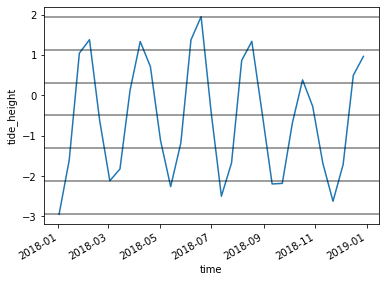

In [250]:
landsat_ds.sortby('time').tide_height.plot()
for i in binInterval: plt.axhline(i, c='black', alpha=0.5)
    

In [251]:
landsat_intervals.isel(tide_interval=-1).vh.shape

(765, 505)

Now that we have a dataset where each image is classified into a discrete range of the tide, we can combine our images into a set of nine individual images that show where land and water is located from low to high tide. 
**This step can take several minutes to process.**

In [252]:
# For each interval, compute the median water index and tide height value
landsat_intervals = (landsat_ds[['tide_interval', 'vv', 'vh', 'tide_height']]
                     .compute()
                     .groupby('tide_interval')
                     .mean(dim='time'))

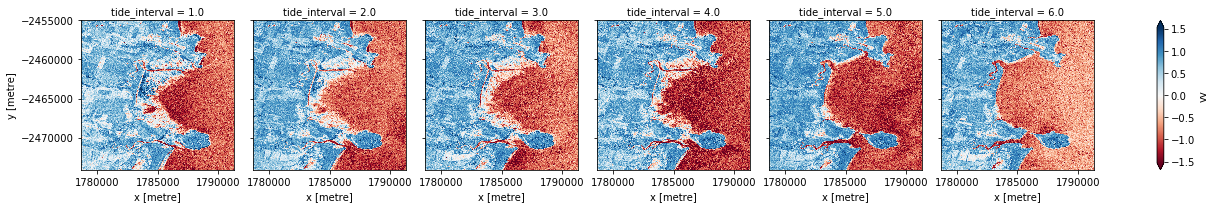

In [263]:
# Plot the resulting set of tidal intervals
landsat_intervals.vv.plot(col='tide_interval', cmap='RdBu', robust=True)
plt.show()

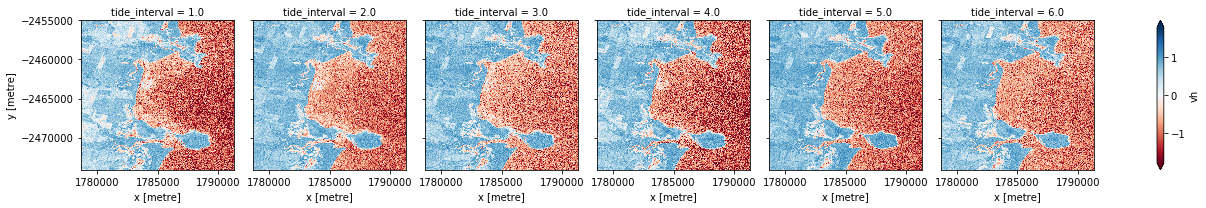

In [264]:
# Plot the resulting set of tidal intervals
landsat_intervals.vh.plot(col='tide_interval', cmap='RdBu', robust=True)
plt.show()

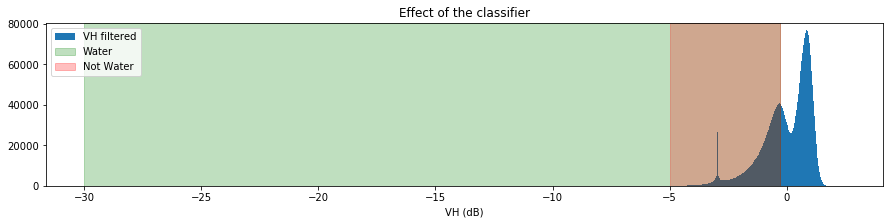

In [255]:
thresh=-0.3

fig, ax = plt.subplots(figsize=(15, 3))
landsat_ds.vh.plot.hist(bins=1000, label="VH filtered")
ax.axvspan(xmin=-30.0, xmax=thresh, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=thresh,
           xmax=-5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

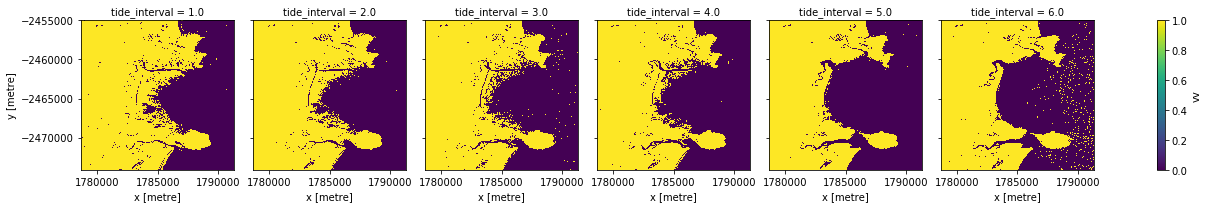

In [256]:
(landsat_intervals.vv > thresh).plot(col='tide_interval')

Operating in single z-value, multiple arrays mode


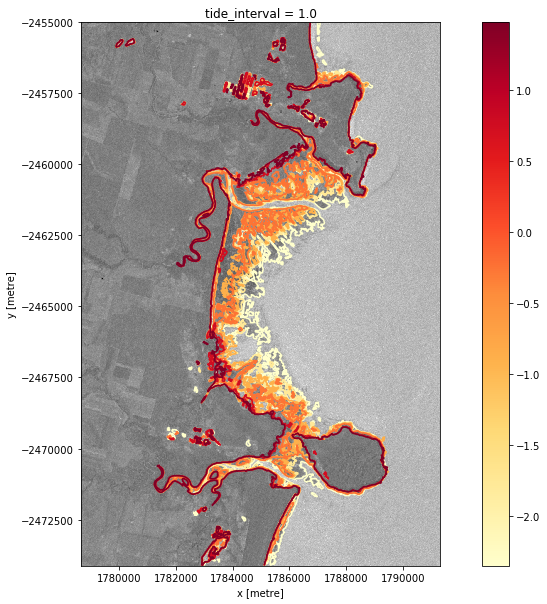

In [257]:
from dea_spatialtools import subpixel_contours

# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_height.values})

# Extract waterlines
contours_gdf = subpixel_contours(da=landsat_intervals.vv,
                                 z_values=thresh,
                                 crs=landsat_ds.crs,
                                 affine=landsat_ds.geobox.transform,
                                 attribute_df=attribute_df,
                                 min_vertices=20,
                                 dim='tide_interval')

# Plot output shapefile over the top of the first tidal interval water index
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
landsat_intervals.vv.sel(tide_interval=1).plot(ax=ax, 
                                                 cmap='Greys', 
                                                 add_colorbar=False)
contours_gdf.plot(ax=ax, column='tide_m', cmap='YlOrRd', legend=True)
plt.show()


While the contours above provide valuable information about the topography of the intertidal zone, we can extract additional information about the 3D structure of the coastline by converting them into an elevation raster (i.e. a Digital Elevation Model or DEM).

In the cell below, we convert the shapefile above into an array of points with X, Y and Z coordinates, where the Z coordinate is the point's elevation relative to Mean Sea Level. 
We then use these XYZ points to interpolate smooth, continuous elevations across the intertidal zone using linear interpolation.

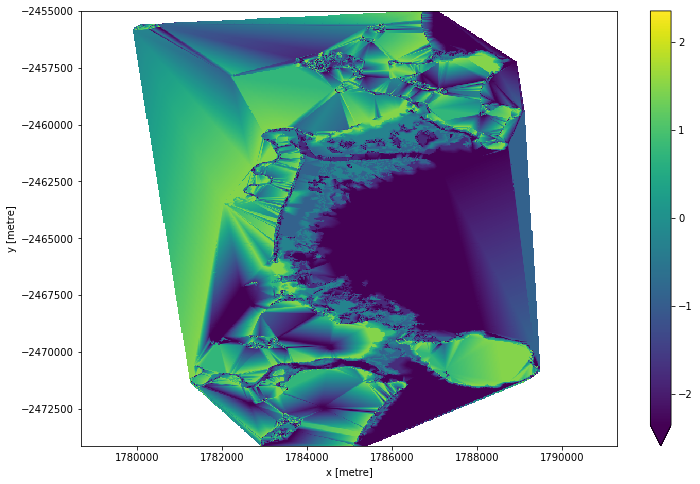

In [258]:
from dea_spatialtools import interpolate_2d
from dea_spatialtools import contours_to_arrays

# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_m')

# Interpolate these XYZ points over the spatial extent of the Landsat dataset
intertidal_dem = interpolate_2d(ds=landsat_intervals,
                                x_coords=xyz_array[:, 0],
                                y_coords=xyz_array[:, 1],
                                z_coords=xyz_array[:, 2])

# Plot the output
intertidal_dem.plot(cmap='viridis', size=8, robust=True)
plt.show()


You can see in the output above that our interpolation results are very messy. 
This is because the interpolation extends across areas of our study area that are not affected by tides (e.g. areas of water located beyond the lowest observed tide, and on land). 
To clean up the data, we can restrict the DEM to only the area between the lowest and highest observed tides:

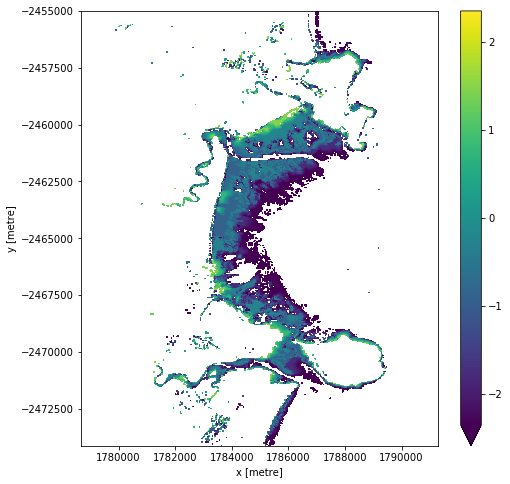

In [260]:
# Identify areas that are always wet (e.g. below low tide), or always dry
above_lowest = landsat_intervals.isel(tide_interval=0).vv > thresh
below_highest = landsat_intervals.isel(tide_interval=-1).vv < thresh

# Keep only pixels between high and low tide
intertidal_dem_clean = intertidal_dem.where(above_lowest & below_highest)

# Plot the cleaned dataset
intertidal_dem_clean.plot(cmap='viridis', size=8, aspect=1.0, vmin=-1, vmax=1)
plt.show()


## Create monthly mean composites

In [10]:
data_mean = data[['vv','vh']].groupby('time.month').mean(dim='time')
data_mean['vhvv'] = data_mean.vh - data_mean.vv

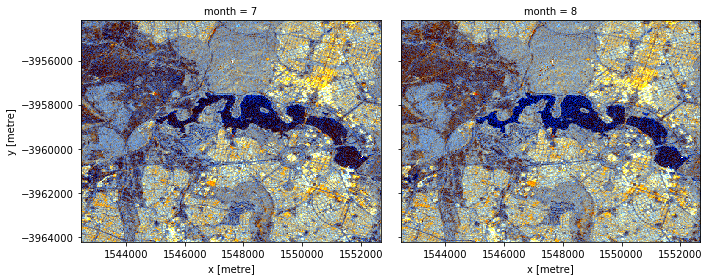

In [11]:
# rescale the data for improved contrast
m, s = data_mean[['vv','vh','vhvv']].mean(), data_mean[['vv','vh','vhvv']].std()
arr_mean = (data_mean[['vv','vh','vhvv']] - m)/s
arr_mean.to_array().plot.imshow(robust=True, col='month', figsize=(10,4));

## Load data with different speckle filter options

In [12]:
query = {'lon': (149.09, 149.12), 
         'lat': (-35.30, -35.27),
         'time': ('2019-06-01', '2019-12-31')
        }
dss = dc.find_datasets(product='s1_gamma0_scene',**query)

In [16]:
# load and convert to decibel
data_db = dc.load(product='s1_gamma0_scene', 
                  speckle_filter=None, db=True, verbose=True, 
                  datasets=[dss[0]],
                  measurements=['vv','vh'],
                  group_by='solar_day', 
                  resampling='bilinear',
                  **query)

Converting to db...


In [17]:
# load, apply lee filter and convert to decibel
data_lee = dc.load(product='s1_gamma0_scene', 
                   speckle_filter='lee', filter_size=5, db=True, verbose=True, 
                   datasets=[dss[0]],
                   measurements=['vv','vh'],
                   group_by='solar_day', 
                   resampling='bilinear',
                   **query)

Applying a lee filter with window size of 5...
Converting to db...


In [18]:
# load all data, apply temporal filter, convert to decibel and keep relevant timeslice
data_temporal = dc.load(product='s1_gamma0_scene', 
                        speckle_filter='temporal', filter_size=3, db=True, verbose=True, 
                        datasets=dss,
                        measurements=['vv','vh'],
                        group_by='solar_day', 
                        resampling='bilinear', 
                        **query).sel(time=data_db.time.values[0])

Applying a temporal filter with window size of 3...
Converting to db...


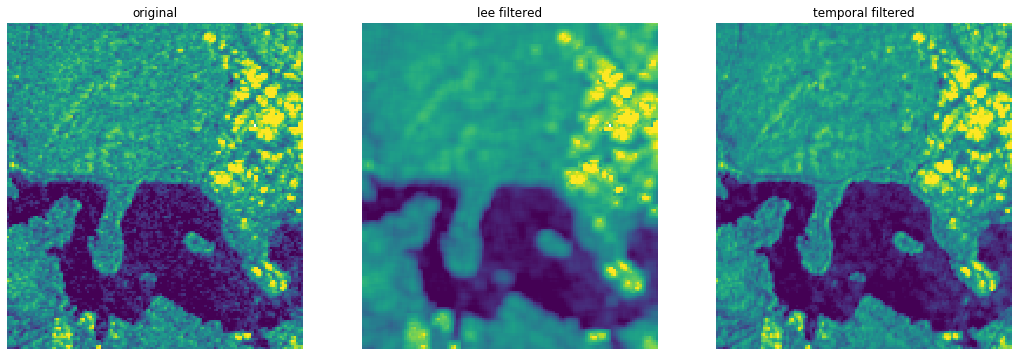

In [19]:
f, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
band = 'vv'
vmin, vmax = -20, 0
data_db.isel(time=0)[band].plot.imshow(add_colorbar=False, vmin=vmin, vmax=vmax, ax=ax[0]);
ax[0].set_title('original');
data_lee.isel(time=0)[band].plot.imshow(add_colorbar=False, vmin=vmin, vmax=vmax, ax=ax[1]);
ax[1].set_title('lee filtered');
data_temporal[band].plot.imshow(add_colorbar=False, vmin=vmin, vmax=vmax, ax=ax[2]);
ax[2].set_title('temporal filtered');


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [17]:
import datacube
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)